In [1]:
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pybounds import Simulator, SlidingEmpiricalObservabilityMatrix, FisherObservability, SlidingFisherObservability, ObservabilityMatrixImage, colorline

# Define system dynamics and measurements
This example uses a model of an insect flying in the presence of wind.

See the following reference for details:

Floris van Breugel
A Nonlinear Observability Analysis of Ambient Wind Estimation with Uncalibrated Sensors, Inspired by Insect Neural Encoding
2021 60th IEEE Conference on Decision and Control (CDC)
DOI: 10.1109/CDC45484.2021.9683219

The system dynamics are described by seven primary states:
* altitude $z$
* parallel velocity $v_{\parallel}$
* perpendicular velocity $v_{\perp}$
* heading $\phi$
* angular velocity $\dot{\phi}$
* wind speed $w$
* wind direction $\zeta$

And the system dynamics are given by
$$
\dot{\mathbf{x}} = \begin{bmatrix} \dot{z} \\ \dot{v}_{\parallel} \\ \dot{v}_{\perp} \\ \dot{\phi} \\ \ddot{\phi} \\ \dot{w}  \\ \dot{\zeta} \end{bmatrix} = 
f(\mathbf{x}) = \begin{bmatrix} 
\dot{z} \\
\frac{1}{m}(k_{m_1}u_{\parallel} - C_{\parallel} a_{\parallel}) + v_{\perp} \dot{\phi} \\
 \frac{1}{m}(k_{m_3}u_{\perp} - C_{\perp} a_{\perp}) - v_{\parallel} \dot{\phi} \\
  \dot{\phi} \\
   \frac{1}{I}(k_{m_4}u_{\phi} - C_{\phi} \dot{\phi} + k_{m_2} u_{\perp}) \\
    \dot{w} \\
     \dot{\zeta} \\
\end{bmatrix}
$$

where the air velocity is given by

$$
\begin{bmatrix} a_{\parallel} \\ a_{\perp} \end{bmatrix} =  \begin{bmatrix} v_{\parallel} - w \cos(\phi - \zeta) \\ v_{\perp} + w \sin(\phi - \zeta) \end{bmatrix}
$$
The inputs $u_{\bullet}$ are
* parallel thrust force $u_{\parallel}$
* perpendicular thrust force $u_{\perp}$
* turning torque $u_{\phi}$

The inertia parameters (mass $m$ and inertia $I$), damping terms $C_{\bullet}$, and motor calibration coefficients $k_{m_{\bullet}}$ can also be considered states. Other auxiliary states, like the $x$ and $y$ position can also be added.

The putative system measurements are:
* heading $\phi$
* ground speed angle $\psi$
* apparent airflow angle $\gamma$
* apparent airflow magnitude $a$
* ground speed magnitude $g$
* optic flow $g/z$

Where the measurement function is given by:

$$
\mathbf{y} = h(\mathbf{x}) = \begin{bmatrix} \phi \\ \psi \\ \gamma  \\ a \\ g \\ r \end{bmatrix} = 
\begin{bmatrix} \phi \\
\arctan(v_{\perp}/ v_{\parallel}) \\
\arctan(a_{\perp} / a_{\parallel}) \\
\sqrt{a_{\parallel}^2 + a_{\perp}^2} \\
\sqrt{v_{\parallel}^2 + v_{\perp}^2} \\
\sqrt{v_{\parallel}^2 + v_{\perp}^2} / z \\
\end{bmatrix}
$$



## Define dynamics function
The dynamics function takes in a list of states $X$ and a list of inputs $U$ and outputs the derivative of the states.

The optional state & input names must be in the same order as the states & inputs in $X$ & $U$.

In [2]:
state_names = ['x',  # x position [m]
               'y',  # y position [m]
               'z',  # z position (altitude) [m]
               'v_para',  # parallel velocity [m/s]
               'v_perp',  # perpendicular velocity [m/s]
               'phi', # heading [rad]
               'phi_dot',  # angular velocity [rad/s]
               'w',  # ambient wind speed [m/s]
               'zeta',  # ambient wind angle [rad]
               'm', # mass [kg]
               'I',  # inertia [kg*m^2]
               'C_para',  # parallel damping [N*s/m]
               'C_perp',  # perpendicular damping [N*s/m]
               'C_phi',  # rotational damping [N·m/rad/s]
               'km1',  # parallel motor calibration coefficient
               'km2',  # offset motor calibration coefficient
               'km3',  # perpendicular motor calibration coefficient
               'km4',  # rotational motor calibration coefficient
               ]

input_names = ['u_para',  # parallel thrust force [N]
               'u_perp',  # perpendicular thrust force [N]
               'u_phi'  # torque [N*m]
               ] 
def f(X, U):
    # States
    x, y, z, v_para, v_perp, phi, phi_dot, w, zeta, m, I, C_para, C_perp, C_phi, km1, km2, km3, km4 = X
    
    # Inputs
    u_para, u_perp, u_phi = U
    
    # Air velocity
    a_para = v_para - w * np.cos(phi - zeta)
    a_perp = v_perp + w * np.sin(phi - zeta)
    
    # Acceleration
    v_para_dot = ((km1 * u_para - C_para * a_para) / m) + (v_perp * phi_dot)
    v_perp_dot = ((km3 * u_perp - C_perp * a_perp) / m) - (v_para * phi_dot)
    
    # Angular acceleration
    phi_ddot = (km4 * u_phi / I) - (C_phi * phi_dot / I) + (km2 * u_para / I)

    # Other dynamics
    x_dot = v_para * np.cos(phi) - v_perp * np.sin(phi)
    y_dot = v_para * np.sin(phi) + v_perp * np.cos(phi)
    z_dot = 0*x
    w_dot = 0*x
    zeta_dot = 0*x
    m_dot = 0*x
    I_dot = 0*x
    C_para_dot = 0*x
    C_perp_dot = 0*x
    C_phi_dot = 0*x
    km1 = 0*x
    km2 = 0*x
    km3 = 0*x
    km4 = 0*x

    # Package and return xdot
    x_dot = [x_dot, y_dot, z_dot, v_para_dot, v_perp_dot, phi_dot, phi_ddot, w_dot, zeta_dot, m_dot, I_dot, C_para_dot, C_perp_dot, C_phi_dot, km1, km2, km3, km4]

    return x_dot

## Define measurement function
The measurement function takes in a list of states $X$ and a list of inputs $U$ and outputs the measurements $Y$.

The optional measurement names must be in the same order as the measurements in $Y$.

In [3]:
measurement_names = ['phi', 'psi', 'gamma', 'a', 'g', 'r']
def h(X, U):
    # States
    x, y, z, v_para, v_perp, phi, phi_dot, w, zeta, m, I, C_para, C_perp, C_phi, km1, km2, km3, km4 = X

    # Inputs
    u_para, u_perp, u_phi = U
    
    # Air velocity
    a_para = v_para - w * np.cos(phi - zeta)
    a_perp = v_perp + w * np.sin(phi - zeta)
    a = np.sqrt(a_para ** 2 + a_perp ** 2)
    gamma = np.arctan2(a_perp, a_para)  # air velocity angle
    
    # Course direction in fly reference frame
    g = np.sqrt(v_para ** 2 + v_perp ** 2)
    psi = np.arctan2(v_perp, v_para)
    
    # Optic flow
    r = g / z
    
    # Unwrap angles
    if np.array(phi).ndim > 0:
        if np.array(phi).shape[0] > 1:
            phi = np.unwrap(phi)
            psi = np.unwrap(psi)
            gamma = np.unwrap(gamma)

    # Measurements
    Y  = [phi, psi, gamma, a, g, r]

    # Return measurement
    return Y


## Set time-step

In [4]:
dt = 0.01  # [s]

# Create simulator object

In [5]:
simulator = Simulator(f, h, dt=dt, state_names=state_names, input_names=input_names, measurement_names=measurement_names)

# Can also set the number of state (n) & inputs (m0 instead of state & input names)
# simulator = Simulator(f, h, dt=dt, n=len(state_names), m=len(input_names))

# Set up model predictive control

In [6]:
# Parameters in SI units
m = 0.25e-6  # [kg]
I = 5.2e-13  # [N*m*s^2] yaw mass moment of inertia: 10.1242/jeb.02369
# I = 4.971e-12  # [N*m*s^2] yaw mass moment of inertia: 10.1242/jeb.038778
C_phi = 27.36e-12  # [N*m*s] yaw damping: 10.1242/jeb.038778
C_para = m / 0.170  # [N*s/m] calculate using the mass and time constant reported in 10.1242/jeb.098665
C_perp = C_para  # assume same as C_para

# Scale Parameters
m = m * 1e6  # [mg]
I = I * 1e6 * (1e3) ** 2  # [mg*mm/s^2 * mm*s^2]
C_phi = C_phi * 1e6 * (1e3) ** 2  # [mg*mm/s^2 *m*s]
C_para = C_para * 1e6  # [mg/s]
C_perp = C_perp * 1e6  # [mg/s]

In [7]:
# Define the set-point(s) to follow
tsim = np.arange(0, 0.4, step=dt)

setpoint = {'x': 0.0 * np.ones_like(tsim),
            'y': 0.0 * np.ones_like(tsim),
            'z': 0.2 * np.ones_like(tsim),
            'v_para': 0.3 * np.ones_like(tsim) + 0.01*tsim,
            'v_perp': 0.01 * np.ones_like(tsim) + 0.01*tsim,
            'phi': (np.pi/4) * np.ones_like(tsim),
            'phi_dot': 0.0*np.ones_like(tsim),
            'w': 0.4 * np.ones_like(tsim),
            'zeta': (np.pi) * np.ones_like(tsim),
            'm': m * np.ones_like(tsim),
            'I': I * np.ones_like(tsim),
            'C_para': C_para * np.ones_like(tsim),
            'C_perp': C_perp * np.ones_like(tsim),
            'C_phi': C_phi * np.ones_like(tsim),
            'km1': 1.0 * np.ones_like(tsim),
            'km2': 0.0 * np.ones_like(tsim),
            'km3': 1.0 * np.ones_like(tsim),
            'km4': 1.0 * np.ones_like(tsim),
            }

# Add a turn
setpoint['phi'][20:] = setpoint['phi'][20] - np.pi/2

# Update the simulator set-point
simulator.update_dict(setpoint, name='setpoint')

In [8]:
# Define cost function: penalize the squared error between parallel & perpendicular velocity and heading
cost = ((simulator.model.x['v_para'] - simulator.model.tvp['v_para_set']) ** 2 + 
        (simulator.model.x['v_perp'] - simulator.model.tvp['v_perp_set']) ** 2 +
        (simulator.model.x['phi'] - simulator.model.tvp['phi_set']) ** 2)

# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)

In [9]:
# Set input penalty: make this small for accurate state following
simulator.mpc.set_rterm(u_para=1e-6, u_perp=1e-6, u_phi=1e-6)

# Run model predictive control

In [10]:
st = time.time()
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, mpc=True, return_full_output=True)
et = time.time()
print('elapsed time:', et-st)

elapsed time: 1.0473663806915283


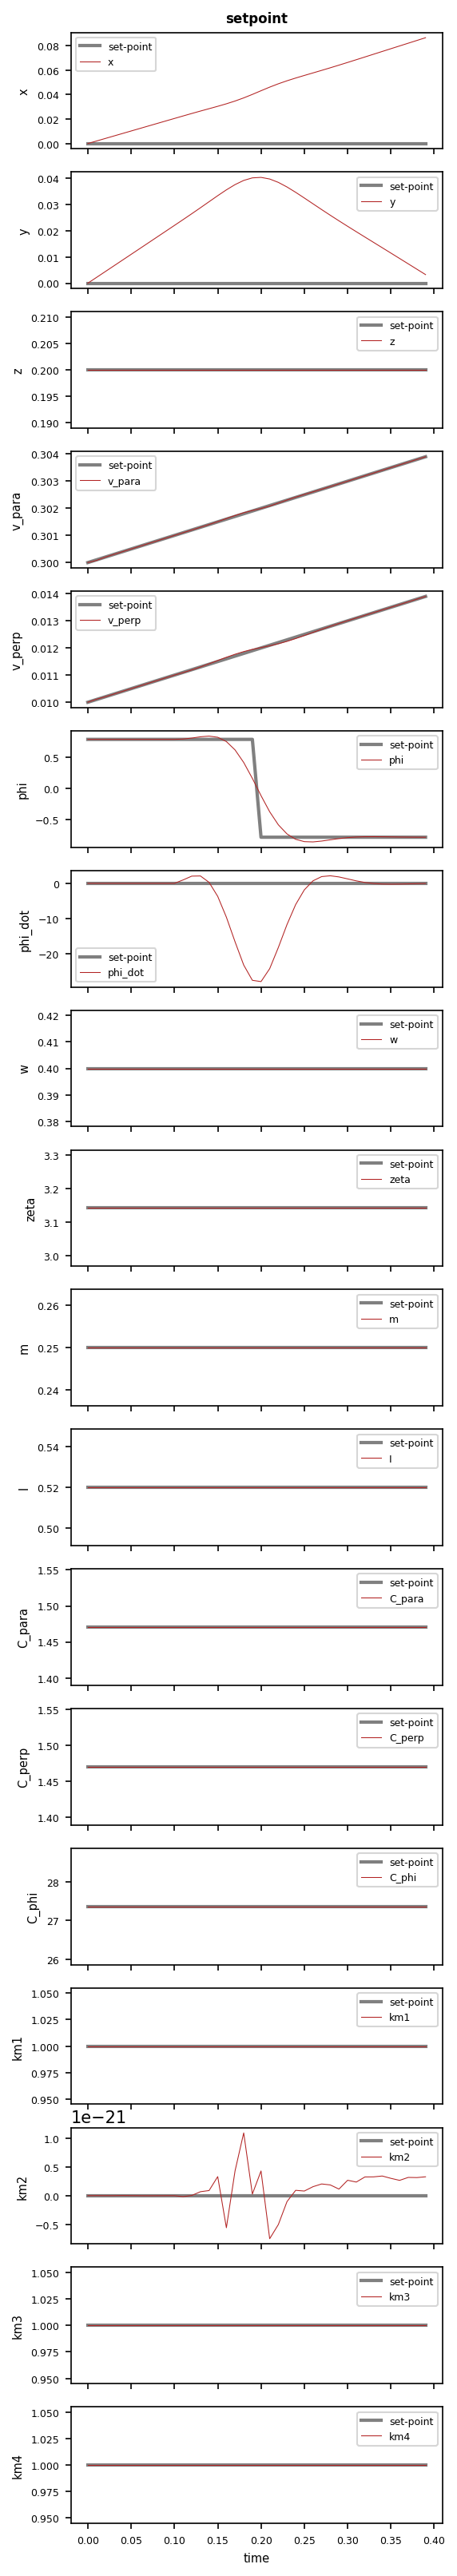

In [11]:
# Plot set-point tracking
# Note that the cost function defined above & the controllability of each state will determine if a set-point is tracked or not
simulator.plot('setpoint')

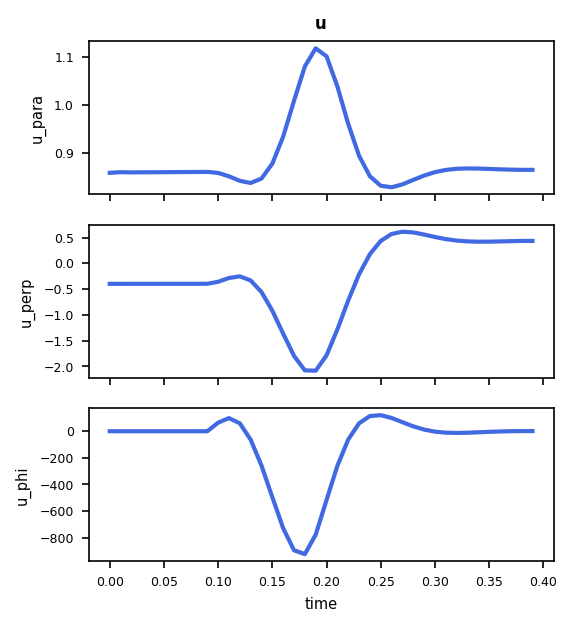

In [12]:
# Plot inputs
simulator.plot('u')

# Re-run simulator with MPC inputs
This step isn't required, but it shows how the closed-loop MOC inputs can be replayed in open-loop to get the same state trajectory

In [13]:
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, mpc=False, u=u_sim, return_full_output=True)

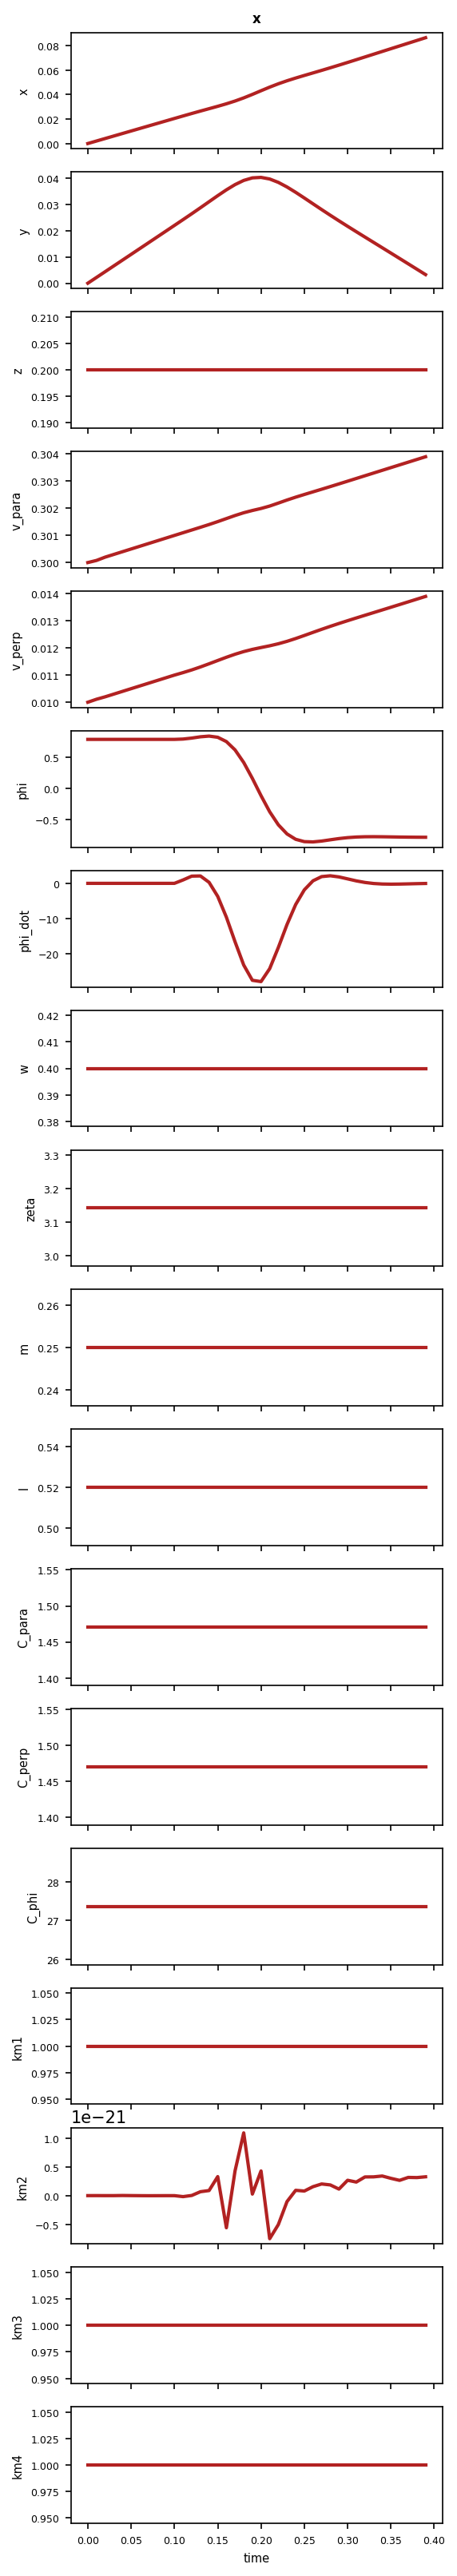

In [14]:
# Plot state
simulator.plot('x')

# Observability

## Construct observability matrix in sliding windows

In [15]:
w = 4  # window size, set to None to use entire time-series as one window

In [16]:
# Construct O in sliding windows
st = time.time()
SEOM = SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)
et = time.time()
print('elapsed time:', et-st)

elapsed time: 2.5306713581085205


In [17]:
# Get O's
O_sliding = SEOM.get_observability_matrix()

In [18]:
n_window = len(O_sliding)
print(n_window, 'windows')

37 windows


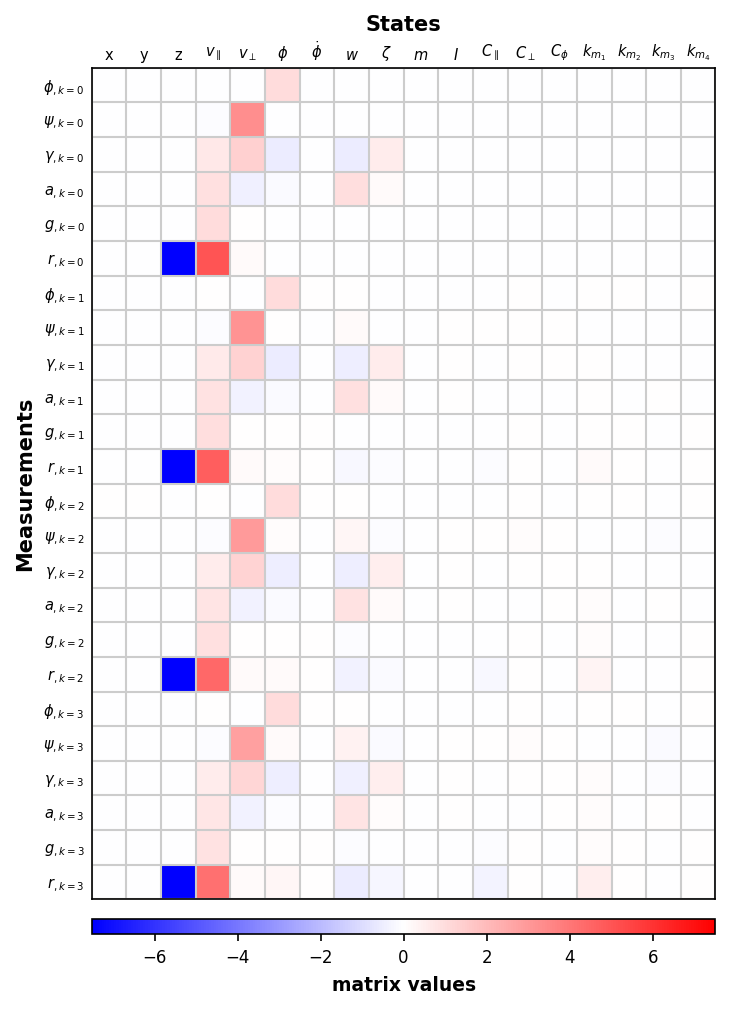

In [19]:
# Visualize first sliding observability matrix, this will throw errors if O is too big
OI = ObservabilityMatrixImage(O_sliding[0], cmap='bwr')
OI.plot(scale=1.0)

## Compute Fisher information matrix & inverse for first window


In [20]:
# Set each sensor noise level
sensor_noise = {'phi': 0.1, 'psi': 0.1, 'gamma': 0.1, 'a': 0.1, 'g': 0.1, 'r': 0.1}

In [21]:
# Compute the Fisher information & Chernoff inverse
FO = FisherObservability(SEOM.O_df_sliding[0], R=None, sensor_noise_dict=sensor_noise, lam=1e-6)

# Can also set R directly as matrix or as scalar
# FO = FisherObservability(SEOM.O_df_sliding[0], R=0.1*np.eye(O_sliding[0].shape[0]), lam=1e-6)
# FO = FisherObservability(SEOM.O_df_sliding[0], R=0.1, lam=1e-6)

In [22]:
# Get the Fisher information, inverse, and R matrix
F, F_inv, R = FO.get_fisher_information()
F_inv

,x,y,z,v_para,v_perp,phi,phi_dot,w,zeta,m,I,C_para,C_perp,C_phi,km1,km2,km3,km4
x,1.000000e+06,-3.606469e-04,-1.103472e-07,-0.000352,-0.000512,-0.000912,0.209032,1.230185e-07,6.179281e-08,-6.840318,0.001541,1.267586,-0.496610,4.518375e-05,0.820845,-4.838439,-0.252826,-0.002038
y,-3.606429e-04,1.000000e+06,-8.667798e-08,-0.000402,-0.000586,-0.001044,0.239251,1.035337e-07,8.630832e-08,-7.823334,0.001763,1.454075,-0.568043,5.169957e-05,0.940978,-5.535319,-0.289273,-0.002331
z,-1.105861e-07,-8.689915e-08,1.153122e-02,0.016632,0.000556,-0.000007,0.000710,-1.136797e-02,-3.040989e-02,-0.009499,-0.000002,0.000934,0.000215,-3.779382e-08,0.000676,0.005359,0.000009,0.000002
v_para,-3.516695e-04,-4.024063e-04,1.663168e-02,0.027136,0.000438,0.000366,-0.021922,-1.710744e-02,-4.548733e-02,-13.131815,0.000334,1.810425,-0.345309,7.542645e-06,1.038738,-0.889697,0.089632,-0.000380
v_perp,-5.124268e-04,-5.863447e-04,5.558432e-04,0.000438,0.006263,-0.000256,0.344984,1.073843e-03,-5.370316e-03,5.805345,0.004336,0.769389,-1.480347,1.382279e-04,0.591651,-14.346452,-0.997460,-0.006036
phi,-9.120199e-04,-1.043891e-03,-7.297960e-06,0.000366,-0.000256,0.067488,-5.119045,8.277808e-06,2.502733e-02,2.885848,-0.007338,1.558201,-2.110367,-1.283172e-04,1.089313,13.505111,-0.998766,0.007321
phi_dot,2.090332e-01,2.392505e-01,7.102369e-04,-0.021922,0.344984,-5.119045,901.897346,-8.114022e-04,-2.644469e-03,-734.445220,13.200954,-374.599813,476.335147,8.771532e-02,-263.933051,-14574.452828,297.932905,-9.260996
w,1.228212e-07,1.041811e-07,-1.136797e-02,-0.017107,0.001074,0.000008,-0.000811,3.615692e-02,4.009973e-02,0.014179,0.000002,-0.017076,-0.022825,-1.380055e-08,0.022278,-0.005816,0.032855,-0.000002
zeta,5.991306e-08,8.861278e-08,-3.040989e-02,-0.045487,-0.005370,0.025027,-0.002644,4.009973e-02,1.903352e-01,0.030146,0.000005,-0.026855,0.021891,-1.460751e-07,0.032416,-0.020785,-0.032659,-0.000009
m,-6.840042e+00,-7.823286e+00,-9.498777e-03,-13.131815,5.805345,2.885848,-734.445220,1.417887e-02,3.014561e-02,395544.453281,-17.324254,62628.532990,10052.318447,-3.279012e-01,47162.835795,18478.175356,-2932.570735,17.940780


## Compute Fisher information matrix & inverse for each sliding window

In [23]:
# Choose sensors to use from O
o_sensors = ['phi', 'psi', 'gamma']

# Chose states to use from O
o_states = ['v_para', 'v_perp', 'phi', 'phi_dot', 'w', 'zeta', 'z', 'm', 'I', 'C_para', 'C_perp', 'C_phi']

# Choose time-steps to use from O
window_size = 4
o_time_steps = np.arange(0, window_size, step=1)

In [24]:
# Compute the Fisher information & inverse for each window and store the minimum error variance
SFO = SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-6, R=None, sensor_noise_dict=sensor_noise,
                                 states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=None)

In [25]:
# Pull out minimum error variance, 'time' column is the time vector shifted forward by w/2 and 'time_initial' is the original time
EV_aligned = SFO.get_minimum_error_variance()

In [26]:
EV_aligned

,time,time_initial,v_para,v_perp,phi,phi_dot,w,zeta,z,m,I,C_para,C_perp,C_phi
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02,0.00,226328.031260,251.555252,0.078679,691.277080,130026.072356,685804.536115,1000000.0,873715.384432,999999.942861,476221.398715,468768.765182,999999.999931
3,0.03,0.01,222914.830377,252.797080,0.078740,692.075219,128665.262020,675456.192464,1000000.0,942820.935632,999999.979657,477118.987290,468916.630449,999999.999927
4,0.04,0.02,227785.373655,262.855333,0.078529,689.356179,129898.820976,689502.823816,1000000.0,998531.241803,999999.914339,477657.873743,469059.735478,999999.999958
5,0.05,0.03,227744.840775,267.807716,0.078530,689.356946,129816.912700,689768.741147,1000000.0,998536.605547,999999.885659,477651.932605,469053.220486,999999.999989
6,0.06,0.04,227672.793396,272.766633,0.078531,689.364515,129725.437000,689941.942109,1000000.0,998535.706533,999999.898166,477646.482263,469046.724662,999999.999999
7,0.07,0.05,227607.305974,277.773645,0.078531,689.369345,129636.191382,690134.141719,1000000.0,998534.975130,999999.930149,477640.794071,469040.414598,999999.999990
8,0.08,0.06,227538.438441,282.817026,0.078519,689.223286,129545.839518,690315.421817,1000000.0,998534.314256,999999.962581,477635.144004,469034.075393,999999.999971
9,0.09,0.07,227457.480759,287.884904,0.078518,689.207678,129451.611252,690459.726532,1000000.0,998532.949516,999999.985795,477630.401938,469027.039443,999999.999952


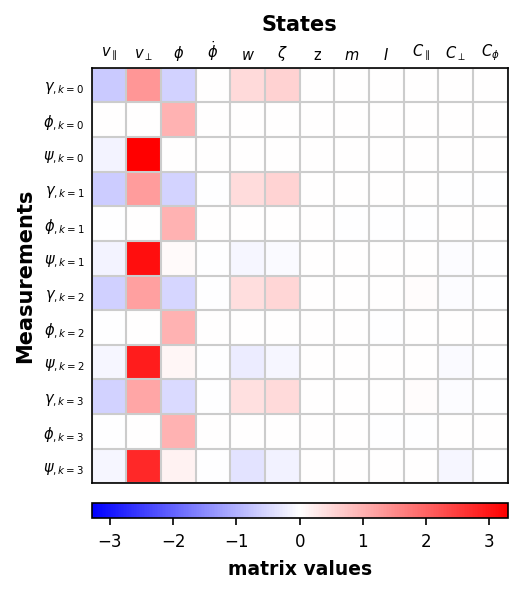

In [27]:
# Visualize observability matrix subset
OI = ObservabilityMatrixImage(SFO.FO[-1].O)
OI.plot()

# Plot error variance as color on state time-series

In [28]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

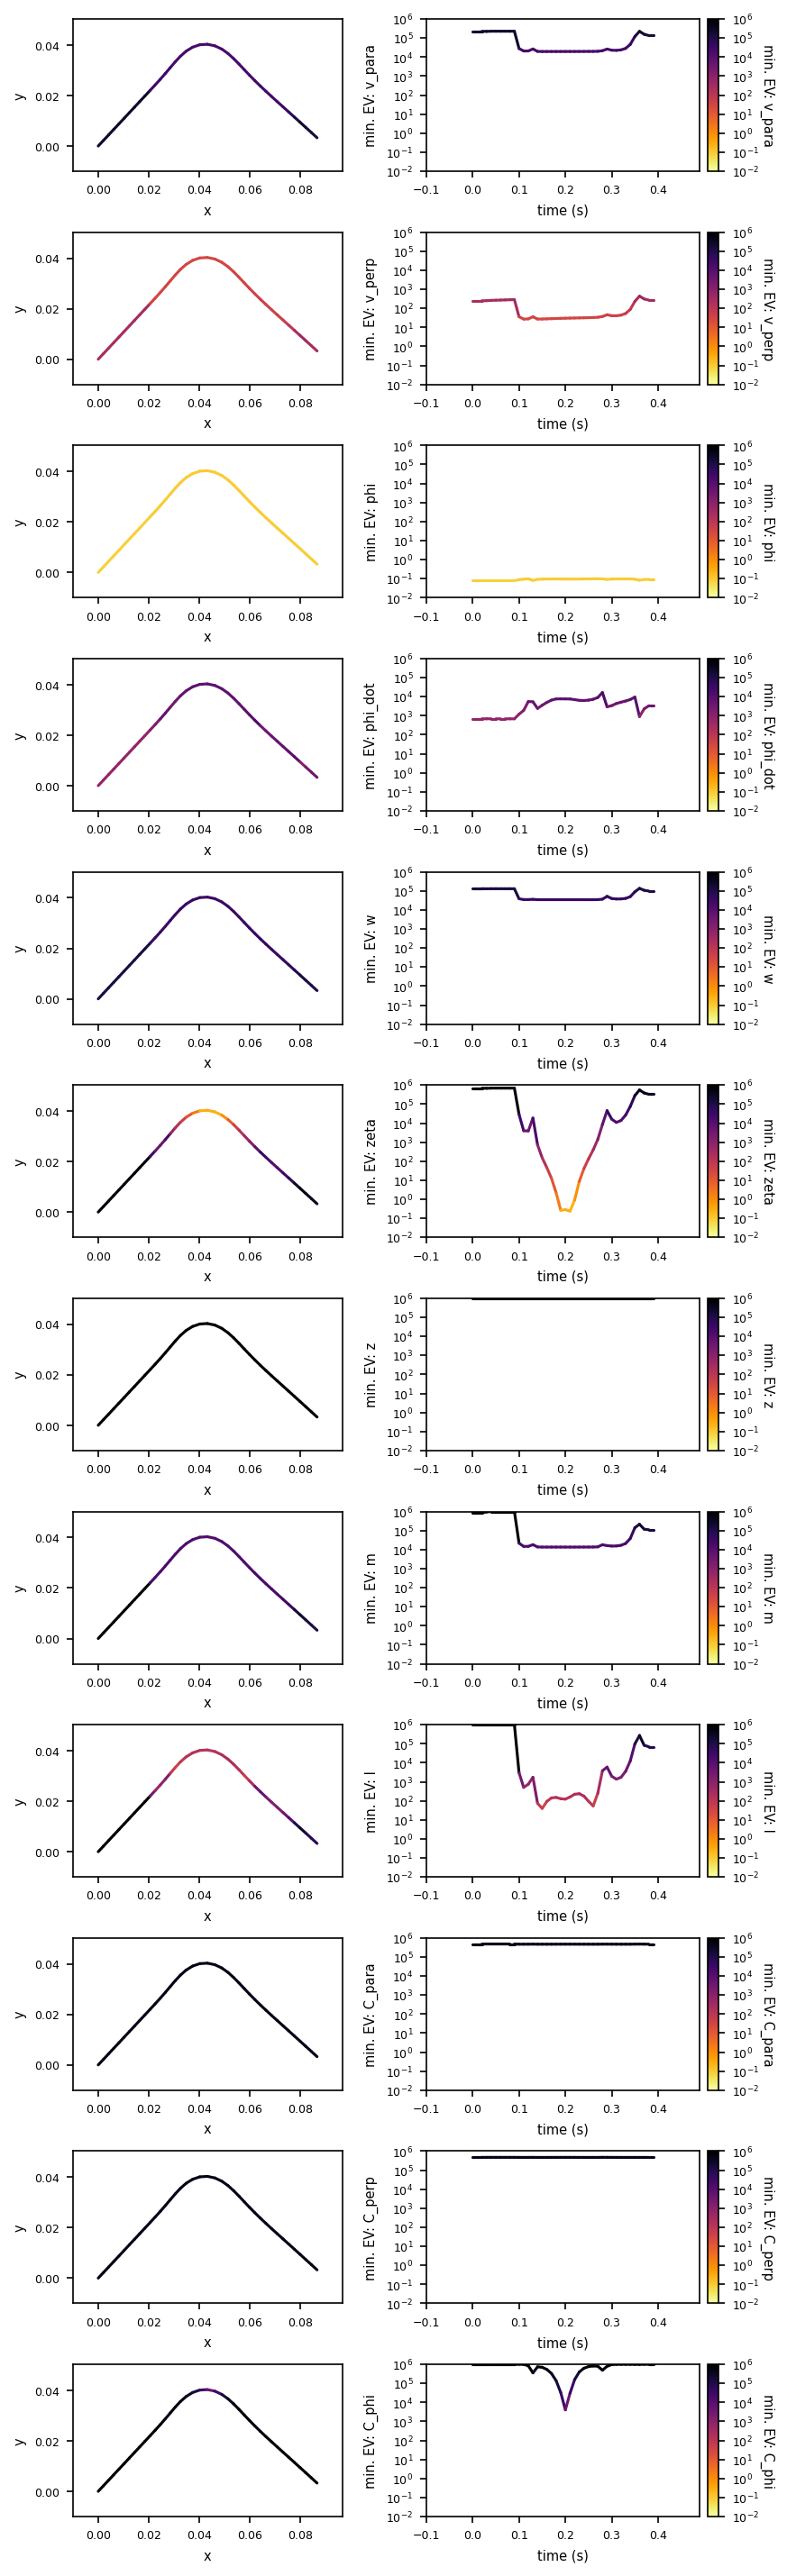

In [29]:
states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'

min_ev = np.min(EV_no_nan.iloc[:, 2:].values)
max_ev = np.max(EV_no_nan.iloc[:, 2:].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(x_sim['x'], x_sim['y'], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)
    
    ax[n, 0].set_ylim(np.min(x_sim['y']) - 0.01, np.max(x_sim['y']) + 0.01)
    ax[n, 0].set_xlim(np.min(x_sim['x']) - 0.01, np.max(x_sim['x']) + 0.01)
    ax[n, 0].set_ylabel('y', fontsize=7)
    ax[n, 0].set_xlabel('x', fontsize=7)
    ax[n, 0].set_aspect(1.0)

    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 1].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 1]:
    a.set_xlabel('time (s)', fontsize=7)
    a.set_xlim(-0.1, t_sim[-1] + 0.1)
    
# for a in ax[:, 1]:
#     a.set_xlim(-0.1, t_sim[-1] + 0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()